In [50]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 

In [51]:
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
# If you're setting the API key directly in your script, uncomment the next line 

def room_setup(scene_descriptor, api_key=api_key):
    url = 'https://api.openai.com/v1/chat/completions'
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json',
            }
    
    # Read the contents of the .py file
    file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
    with open(file_path, 'r') as file:
        file_contents = file.read()

    prompt1 = "I am designing the layout for" + scene_descriptor + ". Please give me the dimensions of the room,"
    prompt1 += " as well as the number of windows, doors, and sockets. For each window, door, and socket tell me the dimensions (in meters),"
    prompt1 += " which wall it should be on, as well as where on the wall it should be (this is a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: "
    prompt1 += "{Room: width = 5,  length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}, etc." 
    prompt1 += "The windows and doors should all have length 0.1. Ensure that every object has dimensions, position, and wall. "
    prompt1 += "No other text please. Just the list with no commentary or explanation."
    response1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt1}],
        max_tokens=500
    )
    objects = response1.choices[0].message.content.split("}, {")

    prompt2 = f"I am going to give you a set of functions that are used to create a room and put objects in it. The functions are as follows:"
    prompt2 += "\n\n{file_contents}\n\n"
    prompt2 += f"I now want, for each element in this list: {objects}, with room descriptor:" + scene_descriptor + ", for you to translate it into a function call using the functions I gave you above."
    prompt2 += " For example, given the room descriptor 'a small kitchen' as well as the list: "
    prompt2 += "{Room: width = 5,  length = 6}, {Object type: window, Number: 1,  width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:"
    prompt2 += "kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3), kitchen.draw()."
    prompt2 += " Return only the python script. No other text. Please ensure the correct number of inputs are given for each function. The code should end with '.draw()'."
    prompt2 += file_contents

    # Define the request payload
    data = {
        "model": "gpt-4",
        "messages": [
            {"role": "user", "content": prompt2}
        ]
    }
    
    # Make the API call
    response2 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response2.status_code == 200:
        response_data2 = response2.json()
        if "```python" in response_data2['choices'][0]['message']['content']:
            response2 = (response_data2['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        elif "```" in response_data2['choices'][0]['message']['content']:
            response2 = (response_data2['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        else: 
            response2 = response_data2['choices'][0]['message']['content']
        print(response2)
        exec(response2)
    else:
        print('Failed to get a response')
        print(response2.text)

    #exec(response_data2['choices'][0]['message']['content'])

    return response1, response2

#scene_descriptor = 'a bedroom for a teenager. The room is 4 meters wide and 6 meters long. There is one big window, 1 door, and 2 electrical plugs. The door should be on the far corner of the south wall.'   
scene_descriptor = "a minimalistic bedroom for a young professional."
response1, response2 = room_setup(scene_descriptor)

KeyboardInterrupt: 

In [ ]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
        }

# Read the contents of the .py file
file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
with open(file_path, 'r') as file:
    file_contents = file.read()

prompt3 = "Interior designers suggest that rooms should have distinct regions in them for different functions. Given the description:"
prompt3 += scene_descriptor
prompt3 += ", what regions should this room have? Pick a reasonable number of these for this room (ensure that the most important are included)"
prompt3 += " and return them in a simple list. For example if the scene description was 'An open plan kitchen dining room', the output would be "
prompt3 += "'cooking region, dining region, cleaning region' etc. Please give no other text."

response3 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt3}],
        max_tokens=500
    )

prompt4 = "For each region in the room described as: " + scene_descriptor + "with regions: " + response3.choices[0].message.content + ", give me all of the constraints/considerations on its position within the room."
prompt4 += " These constraints should depend on the physical features of the room, these are the physical features in the current room:"
prompt4 += response1.choices[0].message.content
prompt4 += ". The constraints should also depend on the other regions. For example, the constraints might be something like"
prompt4 += " 'the cooking region should be near the dining region', 'the sleeping region should have a plug in it'"
prompt4 += " or 'the storage region should be against a wall'. For the final constraint, determine whether there should be a focal point, and which region in the room should be the focal point (and based on the room whether the focal point should be a window or the longest wall in the room). Return a list of these, and keep each"
prompt4 += " constraint/consideration short and simple, but make sure that you include all of the necessary considerations for"
prompt4 += " functionality as well as any design princples you think are important. Give no other text, only the list. Remove any reasoning"
prompt4 += " or explanation for the constraint/consideration. Instead of 'Sleeping region should be near an electrical plug for a bedside lamp or charging devices'"
prompt4 += " just say 'Sleeping region should be near a plug'."

response4 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt4}],
        max_tokens=500
    )

prompt5 = "Given the room so far: " + response2 + ", and the regions: " + response3.choices[0].message.content
prompt5 += " Using the functions in the script, initialise each region. For example 'eating region' might output 'eating_region = region_setup(kitchen, 'eating', 0)."
prompt5 += " End with something like kitchen.draw(draw_regions = True). No other text please, only the python script. Don't include the room so far in the output."
prompt5 += file_contents
 # Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt5}
            ]
    }
    
# Make the API call
response5 = requests.post(url, headers=headers, json=data)  
# Check the response
if response5.status_code == 200:
    response_data5 = response5.json()
    if "```python" in response_data5['choices'][0]['message']['content']:
        response5 = response2 + "\n" + (response_data5['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    else: 
        response5 = response2 + "\n" + response_data5['choices'][0]['message']['content']
    print(response5)
else:
    print('Failed to get a response')
    print(response5.text)

bedroom = create_room(4, 5)
create_fixed_object(bedroom, 'window', 1, 0.1, 'south', position = 0.5)
create_fixed_object(bedroom, 'window', 1, 0.1, 'west', position = 0.7)
create_fixed_object(bedroom, 'door', 0.8, 0.1, 'north', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'east', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'north', position = 0.8)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'west', position = 0.4)
bedroom.draw()
sleeping_region = region_setup(bedroom, 'sleeping', 0)
working_region = region_setup(bedroom, 'working', 1)
storage_region = region_setup(bedroom, 'storage', 2)
relaxation_reading_region = region_setup(bedroom, 'relaxation/reading', 3)

bedroom.draw(draw_regions = True)


positions = np.zeros(2*len(bedroom.regions)) 
for i in range(len(bedroom.regions)): 
    positions[2*(bedroom.regions[i].index)] = bedroom.regions[i].x
    positions[2*(bedroom.regions[i].index) + 1] = bedroom.regions[i].y

def optimize_regions(positions, room): 
    output = 0
    output += reg_close_to_fixed_object(positions, room, 'sleeping', 'socket')
    output += reg_away_from_fixed_object(positions, room, 'sleeping', 'door')
    output += reg_away_from_fixed_object(positions, room, 'sleeping', 'window')
    output += reg_close_to_fixed_object(positions, room, 'working', 'socket')
    output += reg_close_to_wall(positions, room, 'working', None)
    output += reg_close_to_fixed_object(positions, room, 'working', 'window')
    output += reg_away_from_reg(positions, room, 'working', 'sleeping')
    output += reg_close_to_wall(positions, room, 'storage', None)
    output += reg_away_from_fixed_object(positions, room, 'storage', 'window')
    output += reg_away_from_fixed_object(posi

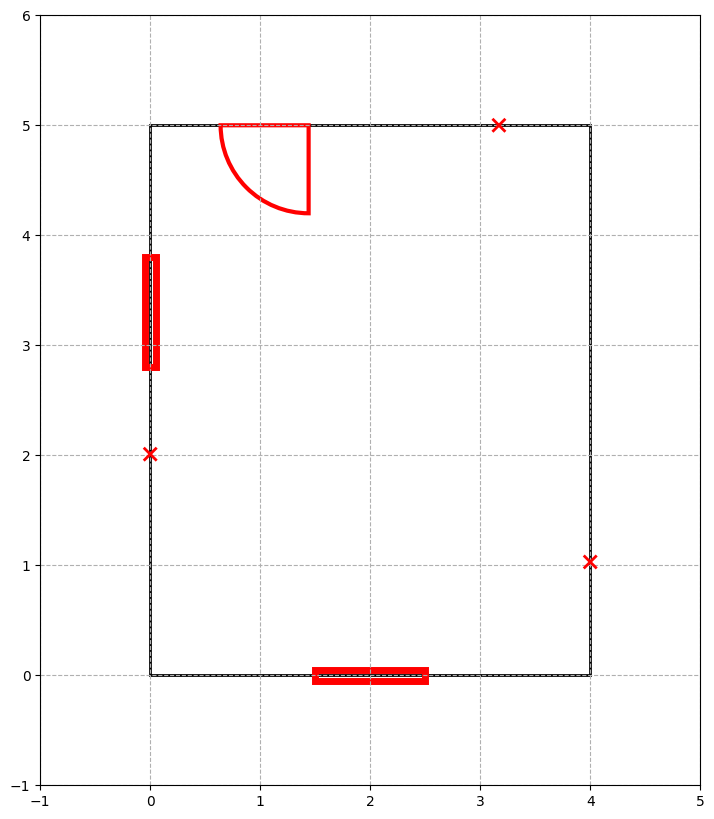

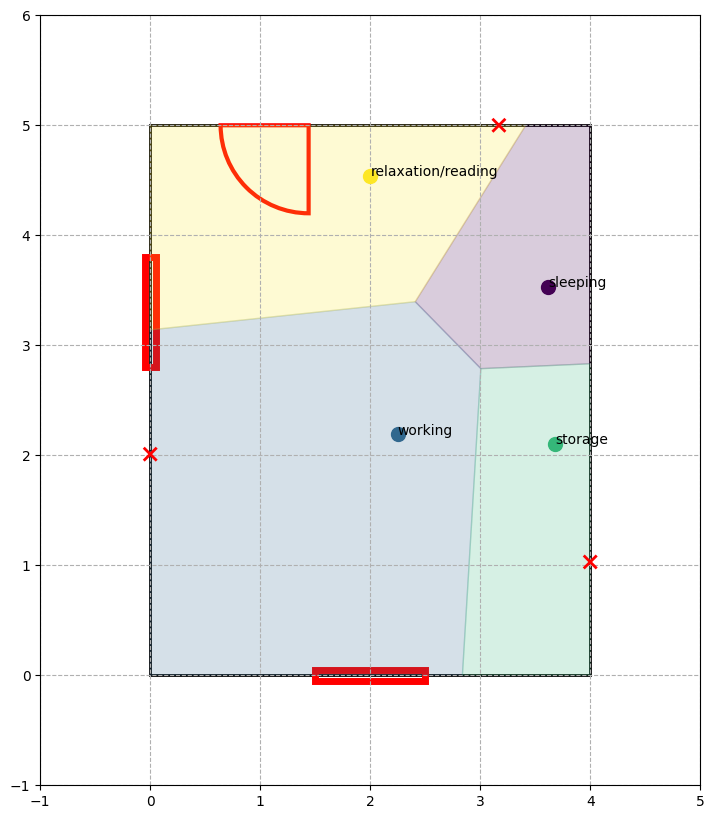

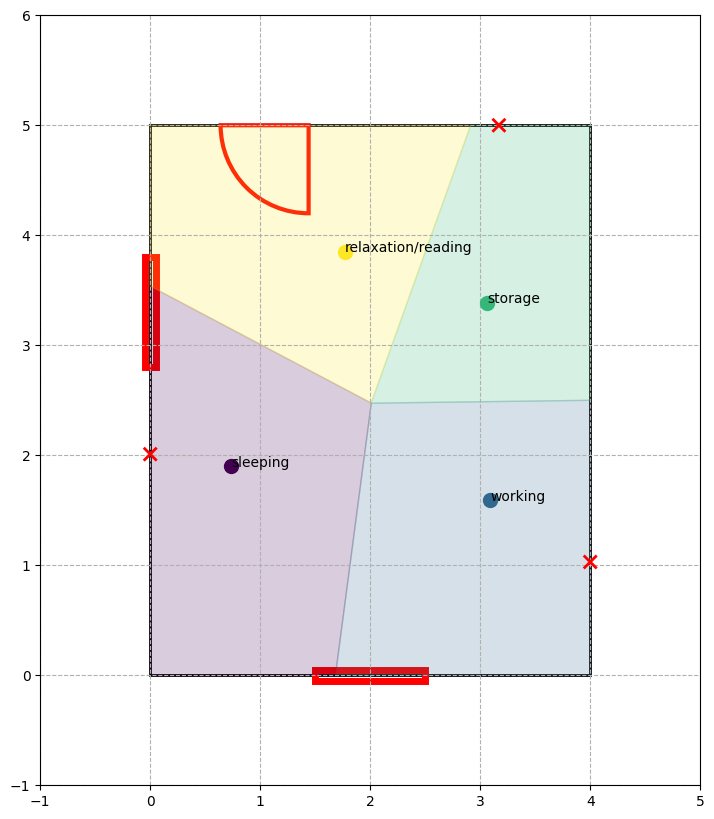

In [ ]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
         }
# Read the contents of the .py file
file_path2 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Region.py'
with open(file_path2, 'r') as file:
    file_contents2 = file.read()


prompt6 = "Given the room set up so far: " + response5
prompt6 += ", and the regions: " + response3.choices[0].message.content + " and the constraints: " + response4.choices[0].message.content
prompt6 += " . Using the script attached, transform each constraint into a function call that will ensure that the regions are set up correctly. Match each constraint"
prompt6 += " to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out."
prompt6 += file_contents2
prompt6 += ". Then, once each point has been transformed to a function call, I then want the output to begin with (change 'room' to be the room name): "
prompt6 += "positions = np.zeros(2*len(room.regions)) \n for i in range(len(room.regions)): \n positions[2*(room.regions[i].index)] = room.regions[i].x"
prompt6 +=  "\n positions[2*(room.regions[i].index) + 1] = room.regions[i].y"
prompt6 += "\n def optimize_regions(positions, room): \n output = 0, followed by each constraint added to the ouput, and then the output returned."
prompt6 += "Finally, add this at the end (replacing 'room' with the name of the room): "
prompt6 += "bounds = Bounds([0] * 2 * len(room.regions), [room.width, room.length] * len(room.regions)) \n"
prompt6 += "res = minimize(optimize_regions, positions, args = (room), method = 'Nelder-Mead', bounds=bounds) \n"
prompt6 += "for i in range(len(room.regions)): \n room.regions[i].x, room.regions[i].y = res.x[2*(room.regions[i].index):2*(room.regions[i].index) + 2] \n"
prompt6 += "room.draw(draw_regions = True). The functions are all already defined in the script, you just need to call them."
prompt6 += "No extra text please, only the functions and the output. Don't have 'python' at the start of the code."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt6}
            ]
    }
    
# Make the API call
response6 = requests.post(url, headers=headers, json=data)  
# Check the response
if response6.status_code == 200:
    response_data6 = response6.json()
    print(response6.json()['choices'][0]['message']['content'])
    if "```python" in response_data6['choices'][0]['message']['content']:
        response6 = (response_data6['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        response6 = response5 + "\n" + response6
    else: 
        response6 = response_data6['choices'][0]['message']['content']
        response6 = response5 + "\n" + response6
    # Create a dictionary to hold the local context
    global_context = globals().copy()
    local_context = {}  
    exec(response6, global_context, local_context)
else:
    print('Failed to get a response')
    print(response6.text)

In [ ]:
room_name = ((response6).split(" =")[0]).split("\n")[-1]

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

room_width = local_context[room_name].width
room_length = local_context[room_name].length

region_names = ""
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
    else: 
        region_names += local_context[room_name].regions[i].name + "."
print(region_names)

sleeping, working, storage, relaxation/reading.


In [ ]:
prompt7 = "I am going to give you a description of a room, as well as all the fixed objects inside it (e.g. windows) and the dimensions of the room."
prompt7 += " I am also going to give you the different regions for the room. Based on this information, "#I want returned the objects for each region "
#prompt7 += "(maximum of 3 - but there can be two of the same object, eg. there could be one bed 2 nightstands or 2 sofas and a coffee table),"
prompt7 += "I want returned the most important or biggest object for each region"
prompt7 += " and the dimensions for those object in meters. This should include width and length, not height. The room description is: "
prompt7 += scene_descriptor + ", and the regions are: " + region_names + ". The fixed objects are: " + fixed_objects
prompt7 += " Finally, the room dimensions are, width : " + str(room_width) + " meters, and length : " + str(room_length) + " meters."
prompt7 += "Please return it in the format of {object_name: name, object_width: width, object_length: length, region: region_name}. After the list, I also want you to give me all the constraints for each object"
prompt7 += " that depend ONLY on the items in the room (e.g. walls, windows, doors, plugs), they cannot depend on any other items in this list. For example if an object should have its back against a wall, or if it should be far away from a window, or near a socket."
prompt7 += "I also want for each object an accessibility constraint about its usage (to prevent the sides being blocked), something like 'the bed should be accessible from the left, right, and front' or 'the sofa should be accessible from the front'. Give all of these as simply as possible, in the following format:  "
prompt7 += "{object_name: name, constraints: [constraint1, constraint2, ...]}. Give no other text in the response. Remove any constraints that involve other objects in the list."

response7 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt7}],
        max_tokens=1000
    )

print(response7.choices[0].message.content)

[
  {object_name: bed, object_width: 1.5, object_length: 2, region: sleeping},
  {object_name: desk, object_width: 1.2, object_length: 0.6, region: working},
  {object_name: wardrobe, object_width: 1, object_length: 2, region: storage},
  {object_name: armchair, object_width: 0.8, object_length: 0.8, region: relaxation/reading}
]

[
  {object_name: bed, constraints: ["should have its back against a wall", "should be far from windows", "should be near a socket", "should be accessible from the left, right, and front"]},
  {object_name: desk, constraints: ["should be near a socket", "should not be against a window", "should be accessible from the chair side"]},
  {object_name: wardrobe, constraints: ["should have its back against a wall", "should be far from windows", "should be accessible from the front"]},
  {object_name: armchair, constraints: ["should be near a socket", "should not block any door", "should be accessible from the front"]}
]


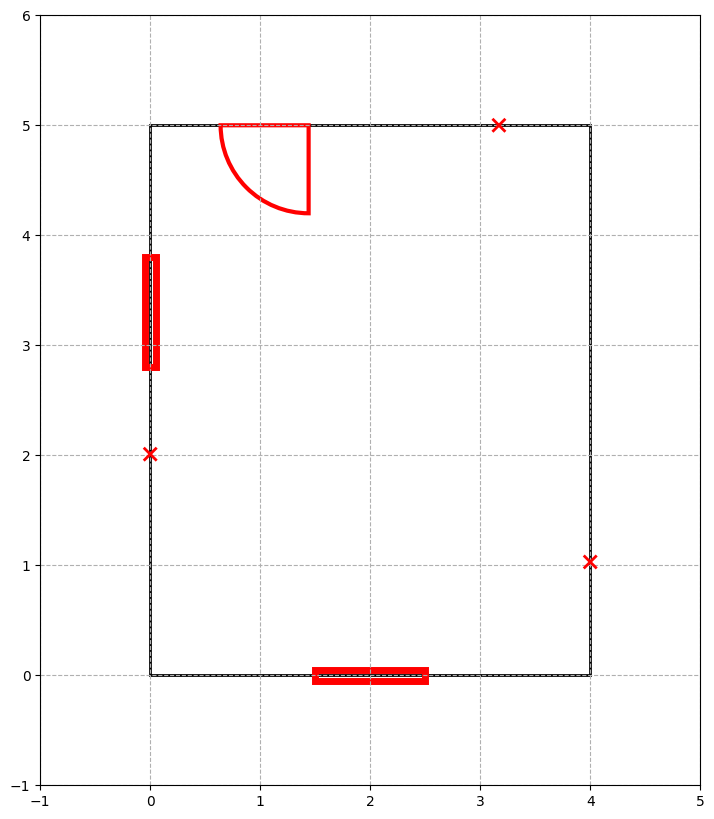

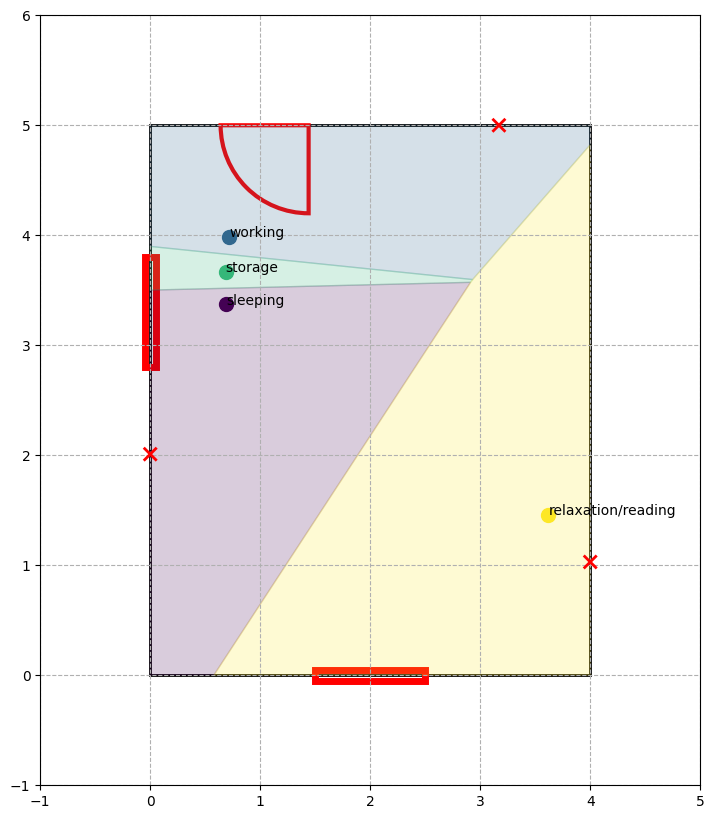

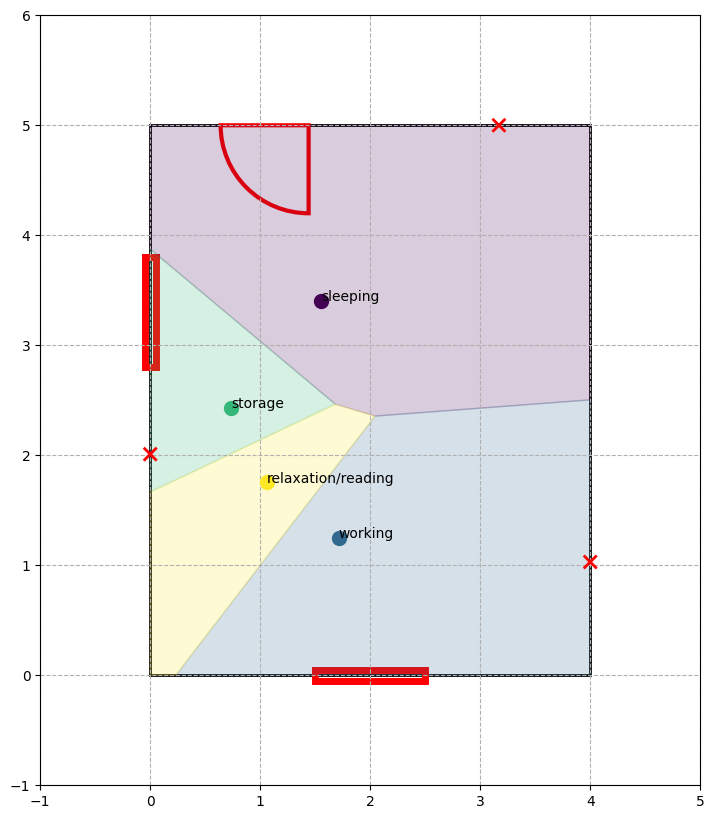

bed [[0.55203048 4.15122345]
 [0.55203048 2.65122345]
 [2.55203048 2.65122345]
 [2.55203048 4.15122345]]
desk [[1.11461506 0.94886674]
 [2.31461506 0.94886674]
 [2.31461506 1.54886674]
 [1.11461506 1.54886674]]
wardrobe [[-0.26250827  2.9291835 ]
 [-0.26250827  1.9291835 ]
 [ 1.73749173  1.9291835 ]
 [ 1.73749173  2.9291835 ]]
wardrobe hi2
armchair [[0.65806009 2.15370433]
 [0.65806009 1.35370433]
 [1.45806009 1.35370433]
 [1.45806009 2.15370433]]


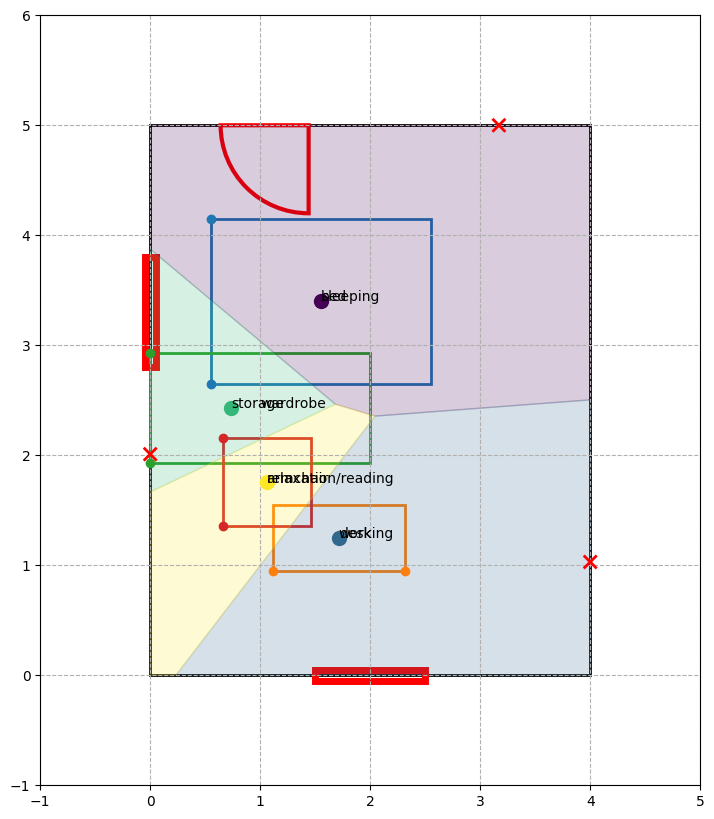

bedroom = create_room(4, 5)
create_fixed_object(bedroom, 'window', 1, 0.1, 'south', position = 0.5)
create_fixed_object(bedroom, 'window', 1, 0.1, 'west', position = 0.7)
create_fixed_object(bedroom, 'door', 0.8, 0.1, 'north', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'east', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'north', position = 0.8)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'west', position = 0.4)
bedroom.draw()
sleeping_region = region_setup(bedroom, 'sleeping', 0)
working_region = region_setup(bedroom, 'working', 1)
storage_region = region_setup(bedroom, 'storage', 2)
relaxation_reading_region = region_setup(bedroom, 'relaxation/reading', 3)

bedroom.draw(draw_regions = True)
positions = np.zeros(2*len(bedroom.regions)) 
for i in range(len(bedroom.regions)): 
    positions[2*(bedroom.regions[i].index)] = bedroom.regions[i].x
    positions[2*(bedroom.regions[i].index) + 1] = bedroom.regions[i].y

def optimize_regions(positi

In [ ]:
prompt8 = "Given this list of the objects: " + response7.choices[0].message.content.split("]")[0] + "], use the file attached to create the objects with the correct parameters."
prompt8 += "The room code so far is: " + response6 + " The code so far should NOT be included in the output."
prompt8 += "The room is already set up, only add in the objects using the 'create_moving_object' function. The regions are: " + region_names + "."
prompt8 += "The objects should be added in the correct regions. The code should end with 'room.draw(draw_regions = True)', Only with 'room' replaced by the room name."
prompt8 += "This is the file: " + file_contents
prompt8 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt8}
            ]
    }
    
# Make the API call
response8 = requests.post(url, headers=headers, json=data)  
# Check the response
if response8.status_code == 200:
    response_data8 = response8.json()
    if "```python" in response8.json()['choices'][0]['message']['content']:
        response8 = response6 + "\n" + (response8.json()['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        exec(response8)
    elif "```" in response8.json()['choices'][0]['message']['content']:
        response8 = response6 + "\n" + (response8.json()['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        exec(response8)
    else:
        response8 = response6 + "\n" + response8.json()['choices'][0]['message']['content']
        exec(response8)
    print(response8)
else:
    print('Failed to get a response')
    print(response8.text)

positions = np.zeros(3*len(bedroom.moving_objects)) 
for i in range(len(bedroom.moving_objects)): 
    positions[3*i] = bedroom.moving_objects[i].position[0]
    positions[3*i + 1] = bedroom.moving_objects[i].position[1] 
    positions[3*i + 2] = bedroom.moving_objects[i].position[2]

def optimize_primary_objects(positions, room): 
    output = 0
    output += ind_next_to_wall(positions, room, 0, side='back')
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_close_to_fixed_object(positions, room, 0, 'socket')
    output += ind_accessible(positions, room, 0, ['left', 'right', 'front'])
    output += ind_close_to_fixed_object(positions, room, 1, 'socket')
    output += ind_away_from_fixed_object(positions, room, 1, 'window')
    output += ind_accessible(positions, room, 1, ['front'])
    output += ind_next_to_wall(positions, room, 2, side='back')
    output += ind_away_from_fixed_object(positions, room, 2, 'window')
    output += ind_accessible(posi

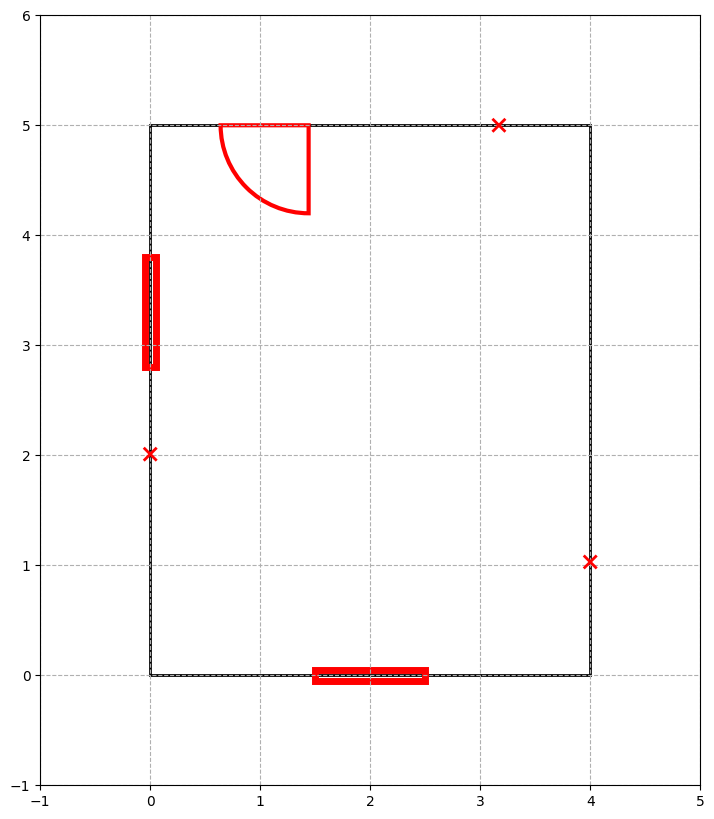

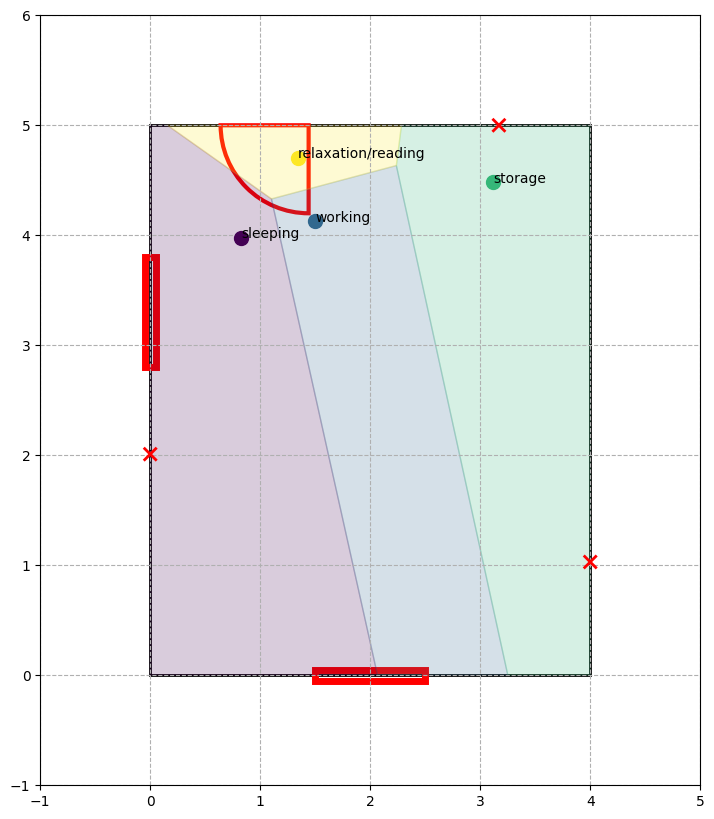

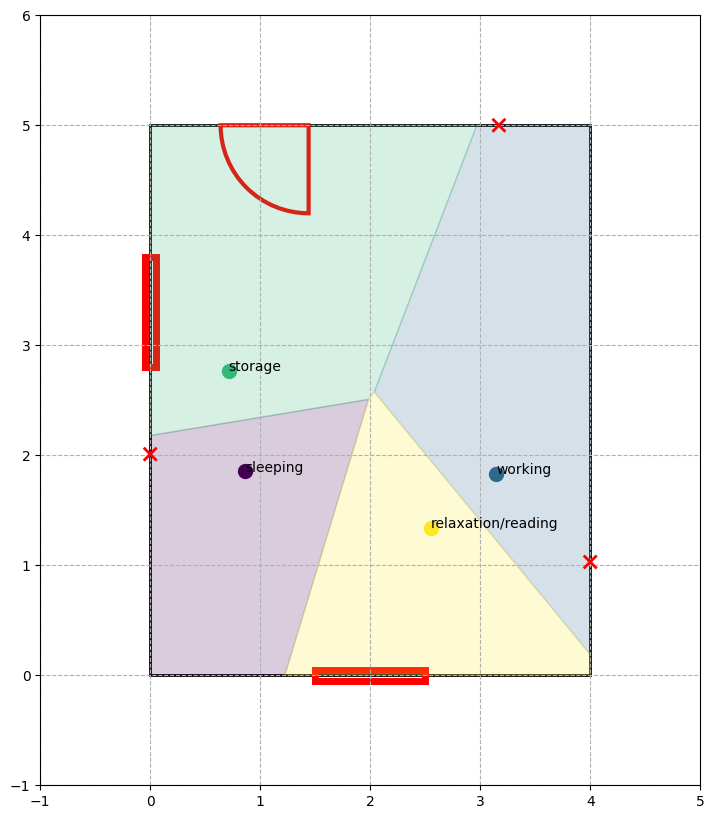

bed [[-0.13607461  2.60405839]
 [-0.13607461  1.10405839]
 [ 1.86392539  1.10405839]
 [ 1.86392539  2.60405839]]
bed hi2
desk [[3.44751375 1.22935082]
 [3.44751375 2.42935082]
 [2.84751375 2.42935082]
 [2.84751375 1.22935082]]
wardrobe [[-0.28692524  3.26511782]
 [-0.28692524  2.26511782]
 [ 1.71307476  2.26511782]
 [ 1.71307476  3.26511782]]
wardrobe hi2
armchair [[2.15419219 0.9413262 ]
 [2.95419219 0.9413262 ]
 [2.95419219 1.7413262 ]
 [2.15419219 1.7413262 ]]


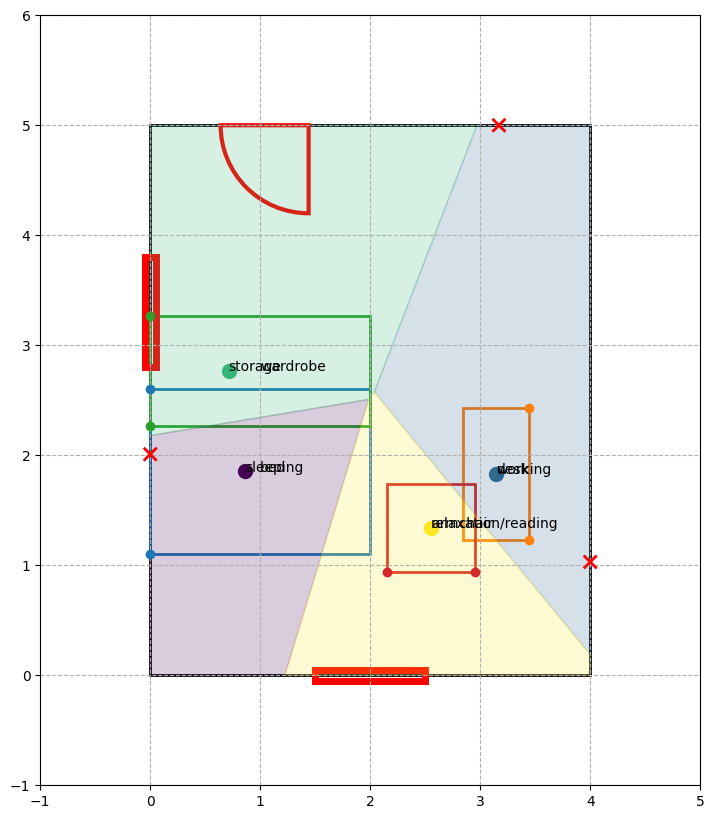

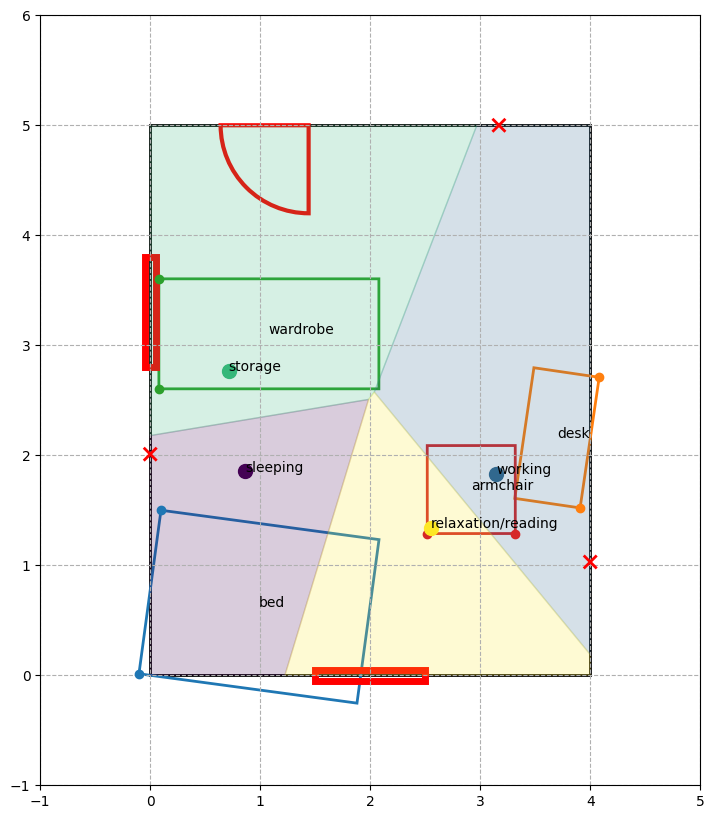

In [ ]:
# Read the contents of the .py file
file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Individual.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()


prompt9 = "Given the room code so far: " + response8
prompt9 += ", as well as the primary objects and their constraints: " + response7.choices[0].message.content
prompt9 += " . Using the script attached, transform each constraint into a function call that will ensure that the primary objects are set up correctly. Match each constraint"
prompt9 += " to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out."
prompt9 += "Here is the script: " + file_contents3
prompt9 += ". I want the output to begin with: "
prompt9 += "positions = np.zeros(3*len(room.moving_objects)) \n for i in range(len(room.moving_objects)): \n positions[3*i] = room.moving_objects[i].position[0]\n"
prompt9 += "positions[3*i + 1] = room.moving_objects[i].position[1] \n positions[3*i + 2] = room.moving_objects[i].position[2] (where 'room' is replaced by whatever the room name is)"
prompt9 += "\n def optimize_primary_objects(positions, room): \n output = 0, followed by each constraint function call added to the ouput, and then the output returned."
prompt9 += "Finally, add this at the end (replacing 'room' with the name of the room): "
prompt9 += "bounds = Bounds([0] * 3 * len(room.moving_objects), [room.width, room.length, 2*np.pi] * len(room.moving_objects))\n"
prompt9 += "cons = [{'type':'eq', 'fun': ind_in_bounds, 'args': (room,)}, {'type':'eq', 'fun': ind_no_overlap, 'args': (room,)}]\n"
prompt9 += "res = minimize(optimize_primary_objects, positions, args = (room), method = 'SLSQP', bounds=bounds, constraints = cons) \n  for i in range(len(room.moving_objects)): \n"
prompt9 += "room.moving_objects[i].position = res.x[3*i:3*i + 3] \n room.draw(draw_regions= True)"
prompt9 += "No extra text please, only the functions and the output.  DON'T include any previous code. DON'T have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt9}
            ]
    }
    
# Make the API call
response9 = requests.post(url, headers=headers, json=data)  
# Check the response
if response9.status_code == 200:
    response_data9 = response9.json()
    print(response9.json()['choices'][0]['message']['content'])
    if "```python" in response9.json()['choices'][0]['message']['content']:
        response9 = response8 + "\n" + (response9.json()['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        print(response9)
        exec(response9)

    elif "```" in response9.json()['choices'][0]['message']['content']:
        response9 = response8 + "\n" + (response9.json()['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        print(response9)
        exec(response9)
    else:
        response9 = response8 + "\n" + response9.json()['choices'][0]['message']['content']
        print(response9)
        exec(response9)
else:
    print('Failed to get a response')
    print(response9.text)
